# Previsão de Churn na Telecom X

## Objetivo

Desenvolver um modelo preditivo que antecipe quais clientes têm maior probabilidade de cancelar os serviços da Telecom X. A previsão de churn permitirá que a empresa atue de forma estratégica, prevenindo perdas e fortalecendo o relacionamento com seus clientes.<br>
  A previsão será de uma classificação binária e o foco principal será a capacidade de generalização do modelo com validação cruzada.

Este projeto busca responder, de forma orientada por dados:

- **Quem são os clientes com maior risco de evasão?**
- **Quais variáveis mais influenciam esse comportamento?**
- **Que tipo de perfil a empresa precisa manter mais próximo?**

## Etapas do Projeto

1. **Exploração e preparação dos dados**
   - Verificação de qualidade e estrutura
   - Exclusão ou transformação de colunas irrelevantes
   - Diagnóstico de desbalanceamento na variável-alvo

2. **Engenharia e análise de variáveis**
   - Criação de atributos derivados 
   - Agrupamento semântico de variáveis categóricas
   - Identificação de correlações relevantes

3. **Transformações para modelagem**
   - Codificação de variáveis categóricas
   - Normalização de variáveis numéricas
   - Preparação do conjunto de treino/teste

4. **Treinamento de modelos preditivos**
   - Modelos a serem aplicados:
     - Regressão Logística (baseline interpretável)
     - Random Forest (modelo de ensemble robusto)
     - XGBoost (modelo com foco em performance)
   - Técnicas para lidar com desbalanceamento 

5. **Avaliação e explicação dos modelos**
   - Métricas: ROC-AUC, F1-Score, Matriz de Confusão, Curva Precision-Recall
   - Análise de importância das variáveis (feature importance)
   - Interpretação dos perfis com maior risco de churn

6. **Conclusão estratégica**
   - Identificação de perfis de clientes críticos
   - Fatores-chave que impulsionam a evasão
   - Recomendações práticas para retenção de clientes com alto risco
   


In [106]:
import pandas as pd
import numpy as np


caminho_arquivo = 'dados_tratados.csv' 
df = pd.read_csv(caminho_arquivo)
df.head(5)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total,qtd_servicos_ativos,nivel_servico,partner_dependents
0,0002-ORFBO,False,Female,False,Yes,Yes,9,Yes,No,DSL,...,Yes,No,One year,Yes,Cheque enviado,65.6,593.30,5,Serviços intermediários,Yes_Yes
1,0003-MKNFE,False,Male,False,No,No,9,Yes,Yes,DSL,...,No,Yes,Month-to-month,No,Cheque enviado,59.9,542.40,4,Serviços intermediários,No_No
2,0004-TLHLJ,True,Male,False,No,No,4,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,Cheque eletrônico,73.9,280.85,3,Serviços intermediários,No_No
3,0011-IGKFF,True,Male,True,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,Month-to-month,Yes,Cheque eletrônico,98.0,1237.85,6,Serviço completo,Yes_No
4,0013-EXCHZ,True,Female,True,Yes,No,3,Yes,No,Fiber optic,...,Yes,No,Month-to-month,Yes,Cheque enviado,83.9,267.40,4,Serviços intermediários,Yes_No


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7032 non-null   object 
 1   Churn                      7032 non-null   bool   
 2   customer_gender            7032 non-null   object 
 3   customer_SeniorCitizen     7032 non-null   bool   
 4   customer_Partner           7032 non-null   object 
 5   customer_Dependents        7032 non-null   object 
 6   customer_tenure            7032 non-null   int64  
 7   phone_PhoneService         7032 non-null   object 
 8   phone_MultipleLines        7032 non-null   object 
 9   internet_InternetService   7032 non-null   object 
 10  internet_OnlineSecurity    7032 non-null   object 
 11  internet_OnlineBackup      7032 non-null   object 
 12  internet_DeviceProtection  7032 non-null   object 
 13  internet_TechSupport       7032 non-null   objec

In [108]:
df.describe()

,customer_tenure,account_Charges.Monthly,account_Charges.Total,qtd_servicos_ativos
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,4.243885
std,24.545260,30.085974,2266.771362,2.306445
min,1.000000,18.250000,18.800000,1.000000
25%,9.000000,35.587500,401.450000,2.000000
50%,29.000000,70.350000,1397.475000,4.000000
75%,55.000000,89.862500,3794.737500,6.000000
max,72.000000,118.750000,8684.800000,9.000000


<b> Aqui separei as colunas por tipo para facilitar os próximos passos

In [109]:
col_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
col_categoricas = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numéricas:", col_numericas)
print("Categóricas:", col_categoricas)


Numéricas: ['customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total', 'qtd_servicos_ativos']
Categóricas: ['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'nivel_servico', 'partner_dependents']


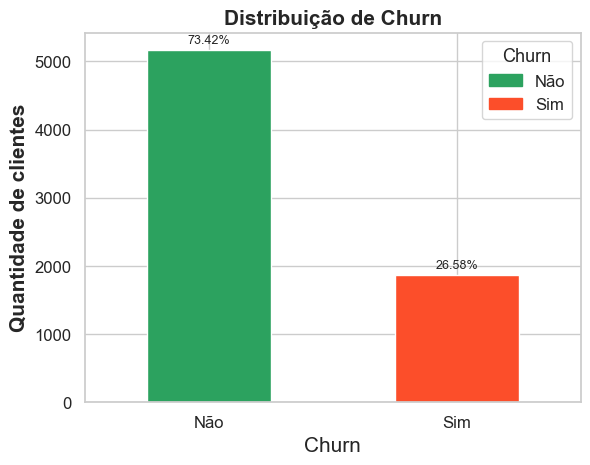

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

sns.set(style="whitegrid")

contagem = df['Churn'].value_counts().sort_index()
porcentagem = contagem / contagem.sum() * 100

cores = ['#2ca25f', '#fc4e2a']


ax = contagem.plot(kind='bar', color=cores, rot=0, title='Distribuição de Churn', fontsize=12)
ax.set_title('Distribuição de Churn', fontsize=15, fontweight=600)
ax.set_xticklabels(['Não', 'Sim'])
ax.set_xlabel('Churn',fontsize=15)
ax.set_ylabel('Quantidade de clientes',fontsize=15, fontweight=600)

# Para colocar as porcentagens em cima das barras
for i, valor in enumerate(contagem):
    ax.text(i, valor + contagem.max()*0.01, f'{porcentagem[i]:.2f}%', ha='center', va='bottom', fontsize=9)


legend_labels = [Patch(color='#2ca25f', label='Não'), Patch(color='#fc4e2a', label='Sim')]
ax.legend(handles=legend_labels, title='Churn', title_fontsize=13, fontsize=12)
plt.show()




<b> Removendo as colunas constantes e irrelevantes pro modelo


In [111]:
limite = 0.90
for col in df.columns:
    dominante = df[col].value_counts(normalize=True).values[0]
    if dominante > limite:
        print(f"Coluna {col} é quase constante ({dominante:.2%}) e deve ser analisada.")


Coluna phone_PhoneService é quase constante (90.33%) e deve ser analisada.


In [112]:
df[col].nunique() == 1


False

In [113]:
df.columns

Index(['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_DeviceProtection', 'internet_TechSupport',
       'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges.Monthly', 'account_Charges.Total',
       'qtd_servicos_ativos', 'nivel_servico', 'partner_dependents'],
      dtype='object')

<b> Remoção da coluna ID por se tratar de uma coluna irrelevante para modelos preditivos 

In [114]:
df_backup = df.copy()

In [115]:
df.drop(columns=['customerID'], inplace=True)

## Análises Direcionadas

Iniciando a investigação de como variáveis específicas se relacionam com a evasão, como:

- Tempo de contrato × Evasão

- Total gasto × Evasão

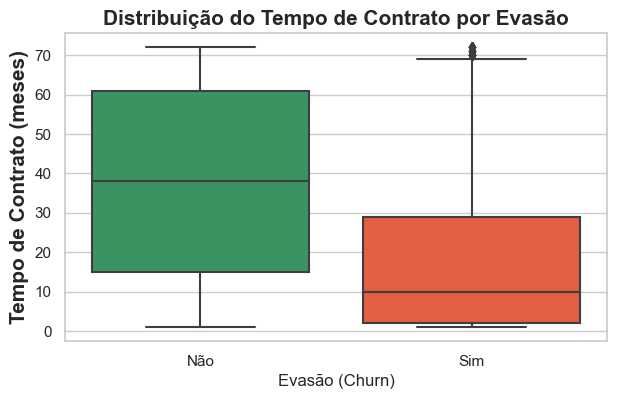

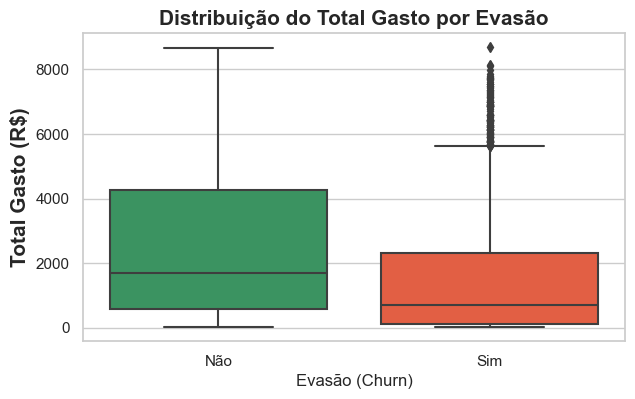

In [116]:
plt.figure(figsize=(7,4))
sns.boxplot(x='Churn', y='customer_tenure', data=df, palette=cores)
plt.xlabel('Evasão (Churn)')
plt.ylabel('Tempo de Contrato (meses)',fontsize=15, fontweight=600)
plt.title('Distribuição do Tempo de Contrato por Evasão',fontsize=15, fontweight=600)
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x='Churn', y='account_Charges.Total', data=df, palette=cores)
plt.xlabel('Evasão (Churn)',)
plt.ylabel('Total Gasto (R$)',fontsize=15, fontweight=600)
plt.title('Distribuição do Total Gasto por Evasão', fontsize=15, fontweight=600)
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()


In [117]:
df['Churn'] = df['Churn'].astype(int)
churn_positive = df[df['Churn'] == 1]


### Função de Análise de Diferença entre Grupos de Churn

Nesta etapa do projeto, desenvolvemos uma função para quantificar e ranquear a relação entre as variáveis explicativas do conjunto de dados e o desfecho `Churn` (0 = cliente ativo, 1 = cliente que cancelou o serviço). 

A função realiza uma análise diferenciada para variáveis categóricas e numéricas:

- **Para variáveis categóricas**, calcula a proporção relativa de cada categoria dentro dos grupos de churn (0 e 1) e obtém a diferença percentual entre esses grupos. Essa métrica evidencia quais categorias têm uma distribuição significativamente distinta entre clientes que cancelaram e os que permaneceram, indicando potencial relevância preditiva.

- **Para variáveis numéricas**, calcula a média em cada grupo de churn e a diferença entre essas médias, o que permite identificar atributos cujo valor médio varia de forma significativa conforme o status de churn, sugerindo influência direta na propensão ao cancelamento.

O ranking gerado pela função, ordenado pela maior diferença absoluta entre grupos, serve como uma forma objetiva de priorizar variáveis para análises subsequentes, seleção de features e interpretação do modelo. 

Essa abordagem facilita a compreensão inicial do comportamento dos dados e contribui para o desenvolvimento de modelos preditivos mais eficientes e interpretáveis, além de fornecer insights estratégicos para ações de retenção de clientes.


In [118]:
import pandas as pd
import numpy as np

def churn_diff_ranking(df, churn_col='Churn'):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if churn_col in num_cols:
        num_cols.remove(churn_col)
    if churn_col in cat_cols:
        cat_cols.remove(churn_col)
    
    results = []

    # Categóricas
    for col in cat_cols:
        prop_churn_0 = df[df[churn_col] == 0][col].value_counts(normalize=True, dropna=False)
        prop_churn_1 = df[df[churn_col] == 1][col].value_counts(normalize=True, dropna=False)
        all_categories = set(prop_churn_0.index).union(set(prop_churn_1.index))
        
        for cat in all_categories:
            val_0 = prop_churn_0.get(cat, 0)
            val_1 = prop_churn_1.get(cat, 0)
            diff = val_1 - val_0
            results.append({
                'feature': col,
                'category': cat,
                'churn_0_pct': val_0 * 100,
                'churn_1_pct': val_1 * 100,
                'diff_pct': diff * 100,
                'abs_diff_pct': abs(diff * 100),
                'type': 'categorical'
            })

    # Numéricas
    for col in num_cols:
        mean_0 = df[df[churn_col] == 0][col].mean()
        mean_1 = df[df[churn_col] == 1][col].mean()
        diff = mean_1 - mean_0
        results.append({
            'feature': col,
            'category': None,
            'churn_0_mean': mean_0,
            'churn_1_mean': mean_1,
            'diff_mean': diff,
            'abs_diff_mean': abs(diff),
            'type': 'numerical'
        })
    
    results_df = pd.DataFrame(results)

    # Ordenação para ranking
    results_df['sort_val'] = results_df.apply(
        lambda x: x['abs_diff_pct'] if x['type']=='categorical' else x['abs_diff_mean'], axis=1
    )
    results_df = results_df.sort_values(by='sort_val', ascending=False).reset_index(drop=True)

    # Formatação das colunas numéricas para 2 casas decimais em string
    def format_value(x, is_pct=True):
        if pd.isnull(x):
            return x
        return f"{x:.2f}" if is_pct else f"{x:.2f}"

    # Aplica formatação nas colunas certas, convertendo para string formatada
    for idx, row in results_df.iterrows():
        if row['type'] == 'categorical':
            results_df.at[idx, 'churn_0_pct'] = format_value(row['churn_0_pct'], True)
            results_df.at[idx, 'churn_1_pct'] = format_value(row['churn_1_pct'], True)
            results_df.at[idx, 'diff_pct'] = format_value(row['diff_pct'], True)
            results_df.at[idx, 'abs_diff_pct'] = format_value(row['abs_diff_pct'], True)
        else:
            results_df.at[idx, 'churn_0_mean'] = format_value(row['churn_0_mean'], False)
            results_df.at[idx, 'churn_1_mean'] = format_value(row['churn_1_mean'], False)
            results_df.at[idx, 'diff_mean'] = format_value(row['diff_mean'], False)
            results_df.at[idx, 'abs_diff_mean'] = format_value(row['abs_diff_mean'], False)

    # Remover coluna auxiliar de ordenação antes de retornar
    results_df = results_df.drop(columns=['sort_val'])

    return results_df


In [119]:
df_result = churn_diff_ranking(df)
print(df_result.head(20))

                      feature                 category churn_0_pct  \
0       account_Charges.Total                     None         NaN   
1            account_Contract           Month-to-month       43.00   
2     internet_OnlineSecurity                       No       39.43   
3        internet_TechSupport                       No       39.24   
4    internet_InternetService              Fiber optic       34.84   
5       account_PaymentMethod        Cheque eletrônico       25.06   
6       internet_OnlineBackup                       No       35.91   
7            account_Contract                 Two year       31.71   
8   internet_DeviceProtection                       No       36.47   
9               nivel_servico  Serviços intermediários       32.83   
10   account_PaperlessBilling                      Yes       53.61   
11   account_PaperlessBilling                       No       46.39   
12       internet_StreamingTV      No internet service       27.25   
13       internet_Te

## Conclusões iniciais

**Análise rápida dos gráficos:**

1. **Total Gasto × Evasão**<br>
 o boxplot mostra que os clientes que não evadiram (verde) têm uma distribuição de gasto total bem mais alta e ampla, com mediana alta e poucos valores bem altos. Já os que evadiram (vermelho) têm um gasto total claramente menor, e a mediana está baixa. Isso sugere que clientes que gastam menos tendem a abandonar o serviço com mais frequência, o que sugere que eles podem estar menos engajados ou achando que não vale a pena continuar pagando.

2. **Tempo de Contrato × Evasão** <br>
  Aqui a diferença é ainda mais nítida! Clientes que permaneceram (verde) têm um tempo de contrato muito maior, com mediana perto de 40 meses e até 70 meses no topo do intervalo. Já os que evadiram (vermelho) têm contratos bem curtos, mediana em torno de 10 meses, indicando que a evasão ocorre rapidamente. o que sugere que quem fica mais tempo é quem está mais satisfeito ou tem mais fidelidade, e a evasão quando ocorre, ocorre cedo.



<b> Transformando Churn em Int para prosseguir com as análises e o modelo

In [15]:
pd.set_option('display.max_rows', None)

df['Churn'] = df['Churn'].astype(int)
df_numeric = df.select_dtypes(include=[np.number])
correlacoes = df_numeric.corr()

print(correlacoes['Churn'].sort_values(ascending=False))


Churn                      1.000000
account_Charges.Monthly    0.192858
qtd_servicos_ativos       -0.021192
account_Charges.Total     -0.199484
customer_tenure           -0.354049
Name: Churn, dtype: float64


## Análise de Correlação com Churn

- **customer_tenure:** correlação negativa moderada (-0,35) — clientes que permanecem mais tempo tendem a cancelar menos.
- **account_Charges.Monthly:** correlação positiva fraca/moderada (+0,19) — cobranças mensais maiores podem aumentar o risco de churn.
- **account_Charges.Total:** correlação negativa fraca (-0,20) — clientes com maior gasto total tendem a ficar mais tempo (menos churn).
- **qtd_servicos_ativos:** correlação praticamente nula (-0,02) — pouca ou nenhuma relação linear com churn.

**Conclusão:** A coluna `qtd_servicos_ativos` é irrelevante para análise preditiva de churn e pode ser removida.


In [16]:
df = df.drop(columns=['qtd_servicos_ativos'])
df.columns

Index(['Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_DeviceProtection', 'internet_TechSupport',
       'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges.Monthly', 'account_Charges.Total', 'nivel_servico',
       'partner_dependents'],
      dtype='object')

### Análise de Correlação com Churn (Variáveis Categóricas)

- **customer_gender:** correlação nula (0,00) — nenhuma relação com churn.  
- **phone_PhoneService:** correlação nula (0,00) — nenhuma relação com churn.  
- **phone_MultipleLines:** correlação praticamente nula (0,04) — pouca ou nenhuma associação com churn.  
- **customer_Partner:** correlação fraca (0,15) — parceiros tendem a cancelar um pouco menos.  
- **customer_SeniorCitizen:** correlação fraca (0,15) — idosos têm leve tendência a cancelar mais.  
- **customer_Dependents:** correlação fraca (0,16) — clientes com dependentes cancelam um pouco menos.  
- **partner_dependents:** correlação fraca (0,18) — efeito similar às variáveis anteriores.  
- **account_PaperlessBilling:** correlação fraca (0,19) — clientes com fatura digital tendem a cancelar mais.  
- **nivel_servico:** correlação fraca/moderada (0,21) — o tipo de serviço influencia moderadamente o churn.  
- **internet_StreamingTV:** correlação fraca/moderada (0,23) — uso de streaming pode afetar o churn.  
- **internet_StreamingMovies:** correlação fraca/moderada (0,23) — efeito similar ao streaming de TV.  
- **internet_DeviceProtection:** correlação moderada (0,28) — clientes com proteção tendem a ficar.  
- **internet_OnlineBackup:** correlação moderada (0,29) — backups estão associados a menor churn.  
- **account_PaymentMethod:** correlação moderada (0,30) — o método de pagamento tem influência no churn.  
- **internet_InternetService:** correlação moderada (0,32) — o tipo de serviço de internet impacta o churn.  
- **internet_TechSupport:** correlação moderada (0,34) — suporte técnico reduz o risco de churn.  
- **internet_OnlineSecurity:** correlação moderada (0,35) — segurança online está associada a maior permanência.  
- **account_Contract:** correlação forte (0,41) — o tipo de contrato é o fator categórico mais influente no churn.  

---

**Conclusão:** As colunas `customer_gender`, `phone_PhoneService` e `phone_MultipleLines` apresentam correlação nula ou praticamente nula com churn e **podem ser removidas** da análise preditiva.
- **internet_StreamingTV:** e **internet_StreamingMovies:** podem apresentar multicolenairidade.



In [17]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))    
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

colunas_cat = df.select_dtypes(include=['object', 'category', 'bool'])

# função que calcula o Cramér's V para cada coluna em relação ao Churn e armazenar os resultados
resultados = {}

for col in colunas_cat:
    v = cramers_v(df[col], df['Churn'])
    resultados[col] = v

df_cramers = pd.DataFrame.from_dict(resultados, orient='index', columns=["Cramér's V"])
df_cramers = df_cramers.sort_values(by="Cramér's V", ascending=False)

df_cramers


,Cramér's V
account_Contract,0.409242
internet_OnlineSecurity,0.346607
internet_TechSupport,0.342115
internet_InternetService,0.321490
account_PaymentMethod,0.302276
internet_OnlineBackup,0.291435
internet_DeviceProtection,0.280672
internet_StreamingMovies,0.230101
internet_StreamingTV,0.229541
nivel_servico,0.214567


In [18]:
colunas_irrelevantes = ['customer_gender', 'phone_PhoneService', 'phone_MultipleLines']
df = df.drop(columns=colunas_irrelevantes)


### Nota
<b> Abaixo direciono a análise para considerar as outras correlações fracas/moderadas.

In [19]:
df['nivel_servico']

0       Serviços intermediários
1       Serviços intermediários
2       Serviços intermediários
3              Serviço completo
4       Serviços intermediários
5       Serviços intermediários
6              Serviço completo
7       Serviços intermediários
8       Serviços intermediários
9              Serviço completo
10      Serviços intermediários
11             Serviço completo
12             Serviços básicos
13             Serviço completo
14             Serviço completo
15             Serviço completo
16             Serviço completo
17      Serviços intermediários
18      Serviços intermediários
19             Serviços básicos
20             Serviços básicos
21             Serviço completo
22      Serviços intermediários
23             Serviços básicos
24             Serviços básicos
25      Serviços intermediários
26             Serviço completo
27             Serviços básicos
28             Serviços básicos
29             Serviços básicos
30      Serviços intermediários
31      

In [20]:
print(df['internet_OnlineSecurity'].unique())
print(df['internet_TechSupport'].unique())
print(df['internet_InternetService'].unique())


['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['DSL' 'Fiber optic' 'No']


### Nota
<b> Identifiquei algo que eu não havia explorado anteriormente durante o tratamento de dados, que é a presença de 'No internet service', uma variável que pode importante para definir corretamente os níveis de serviços

In [21]:
df['internet_InternetService'].value_counts()

Fiber optic    3096
DSL            2416
No             1520
Name: internet_InternetService, dtype: int64

In [22]:
df.groupby('internet_InternetService')['Churn'].mean()


internet_InternetService
DSL            0.189983
Fiber optic    0.418928
No             0.074342
Name: Churn, dtype: float64

### Nota
<b> Conferindo se internet_streamingtv e movies são a mesma coisa

In [23]:
df_temp = df[['internet_StreamingTV', 'internet_StreamingMovies']].replace({'Yes': 1, 'No': 0, 'No internet service': 0})


In [24]:
corr_streaming = df_temp.corr().iloc[0, 1]
print(f"Correlação entre StreamingTV e StreamingMovies: {corr_streaming:.4f}")


Correlação entre StreamingTV e StreamingMovies: 0.5334


'''Têm coleinaridade média, portanto vou mantê-las separadas'''

### Nota
<b> Para não tornar essa análise inviesada vou fazer a diferenciação entre clientes com internet e sem internet.

In [25]:
com_internet = df[df['internet_InternetService'] != 'No'].copy()
sem_internet = df[df['internet_InternetService'] == 'No'].copy()

In [26]:
colunas_servico = []

for col in df.columns:
    if df[col].isin(['No internet service']).any():
        colunas_servico.append(col)

print(colunas_servico)


['internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies']


### Explorando o perfil de serviços contratados pelos clientes

Nesta etapa, eu quis entender melhor como os serviços contratados pelos clientes se relacionam com o churn e transformar essas informações em variáveis úteis para análise e modelagem preditiva.

1. **Criando uma variável ponderada por impacto no churn:**  
   Atribuí pesos a cada tipo de serviço (como suporte técnico, backup online, streaming, etc.) com base em sua correlação com churn (usando Cramér’s V). Isso gerou a variável `nivel_servico_ponderado`, que resume o quanto cada cliente utiliza serviços que realmente fazem diferença na decisão de cancelamento.

2. **Usando PCA para revelar padrões escondidos:**  
   Para reduzir a dimensionalidade e extrair padrões mais abstratos do uso dos serviços, apliquei PCA nas variáveis ponderadas. Os componentes principais `pca_1` e `pca_2` revelam dois eixos interessantes:
   - `pca_1` mostra o “nível geral de contratação”, clientes que usam de tudo um pouco.
   - `pca_2` separa quem prioriza segurança/suporte de quem é mais fã de streaming. Bem legal!

3. **Agrupando perfis com KMeans:**  
   Com esses dois componentes (`pca_1` e `pca_2`), apliquei KMeans para segmentar os clientes em grupos com perfis de serviço parecidos. Essa nova variável, `perfil_servico`, pode ajudar bastante na segmentação, análise de churn por grupo e também como feature adicional em modelos.


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

df_servico_bin = com_internet[colunas_servico].replace({
    'Yes': 1,
    'No': 0,
    'No internet service': 0, 
})
# aqui utilizei a analise de V Cramers para ponderar os serviços
cramers_v_scores = {
    'internet_OnlineSecurity': 0.35,
    'internet_TechSupport': 0.34,
    'internet_OnlineBackup': 0.29,
    'internet_DeviceProtection': 0.28,
    'internet_StreamingTV': 0.23,
    'internet_StreamingMovies': 0.23,
}

for col in df_servico_bin.columns:
    peso = cramers_v_scores.get(col, 0)
    df_servico_bin[col] = df_servico_bin[col] * peso

# criar uma variável ponderada pra diferenciar clientes que tem internet, para diferenciar de clientes que tem e não usam
com_internet['nivel_servico_ponderado'] = df_servico_bin.sum(axis=1)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_servico_bin)

# aplicando PCA de 2 componentes
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

com_internet['pca_1'] = pca_components[:, 0]
com_internet['pca_2'] = pca_components[:, 1]

# Agrupando os perfis dos clientes em 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
com_internet['perfil_servico'] = kmeans.fit_predict(pca_components)

sem_internet['nivel_servico_ponderado'] = 0
sem_internet['pca_1'] = 0
sem_internet['pca_2'] = 0
sem_internet['perfil_servico'] = -1  # indica grupo separado, sem internet

df = pd.concat([com_internet, sem_internet], axis=0)
df = df.sort_index()

print(df[['nivel_servico_ponderado', 'pca_1', 'pca_2', 'perfil_servico']].head())

   nivel_servico_ponderado     pca_1     pca_2  perfil_servico
0                     0.86  0.285107  0.369307               2
1                     0.23 -1.229128 -0.969332               1
2                     0.28 -1.211791 -0.171694               1
3                     1.03  1.308200 -1.399359               0
4                     0.57 -0.406983 -0.194264               1


In [28]:
df.groupby('perfil_servico')['nivel_servico_ponderado'].describe()


,count,mean,std,min,25%,50%,75%,max
perfil_servico,,,,,,,,
-1,1520.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
0,1944.0,1.150062,0.329662,0.74,0.80,1.09,1.38,1.72
1,2114.0,0.252143,0.204535,0.00,0.00,0.28,0.46,0.58
2,1454.0,0.866719,0.318819,0.35,0.63,0.87,1.15,1.49


- O cluster -1 identifica quem não tem internet (nível zero em serviços).

- O cluster 0 parece ser um grupo de clientes que contratam diversos serviços adicionais (nível ponderado alto).

- O cluster 2 é um grupo intermediário, contratando alguns serviços.

- O cluster 1 é o grupo com menor nível de serviços adicionais, só o básico ou quase nada.

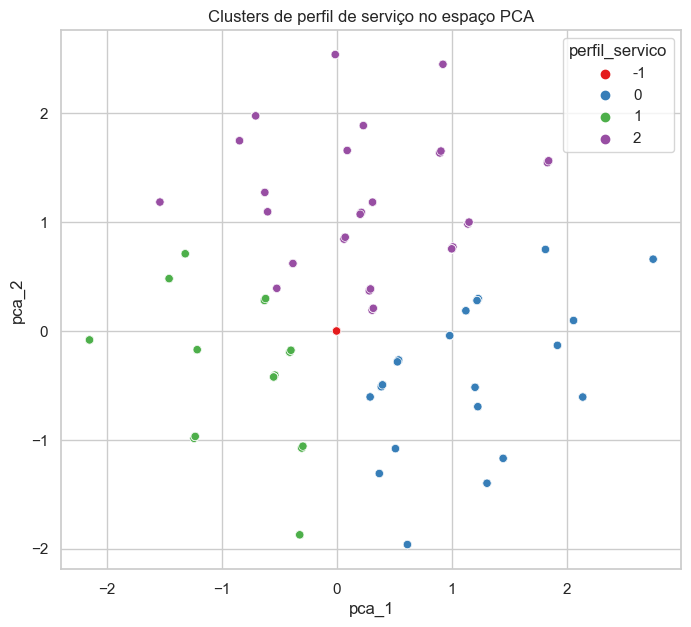

In [29]:
plt.figure(figsize=(8,7))
sns.scatterplot(x='pca_1', y='pca_2', hue='perfil_servico', data=df, palette='Set1')
plt.title('Clusters de perfil de serviço no espaço PCA')
plt.show()


In [30]:
loadings = pd.DataFrame(pca.components_.T, index=colunas_servico, columns=['PC1', 'PC2'])
print(loadings)


                                PC1       PC2
internet_OnlineSecurity    0.294851  0.610302
internet_OnlineBackup      0.343541  0.279746
internet_DeviceProtection  0.464680 -0.044377
internet_TechSupport       0.401924  0.382484
internet_StreamingTV       0.454320 -0.452000
internet_StreamingMovies   0.459528 -0.443516


### Análise PCA dos Perfis de Clientes

O gráfico de PCA mostra a distribuição dos clientes segundo duas componentes principais (PC1 no eixo horizontal e PC2 no vertical), que capturam a maior parte da variabilidade dos serviços contratados.

- **PC1** está fortemente associada a serviços como *Tech Support* (0.46), *Streaming Movies* (0.46) e *Streaming TV* (0.45), refletindo um perfil de clientes com alta demanda por suporte técnico e conteúdo de streaming.
- **PC2** destaca principalmente *Online Security* (0.61) e *Online Backup* (0.38), indicando outra dimensão relacionada à segurança e proteção de dados.

Os clusters revelam grupos bem distintos:
- **Cluster Azul (0)**: Clientes com alto consumo e diversidade de serviços, fãs de streaming e suporte.
- **Cluster Verde (1)**: Usuários mais econômicos, com menor adesão geral aos serviços.
- **Cluster Roxo (2)**: Perfil intermediário, equilibrando segurança e entretenimento.
- **Cluster Vermelho (-1)**: Clientes sem internet, agrupados no centro (0,0), sem variabilidade nos serviços.

Essa separação clara reforça a eficácia da PCA em destacar padrões latentes nos perfis de uso, abrindo caminho para estratégias de marketing segmentadas e ofertas personalizadas que é um passo animador para entendermos melhor nossos clientes!



<b> Binarizando as colunas serviços

In [31]:
df[colunas_servico] = df[colunas_servico].replace({
    'Yes': 1,
    'No': 0,
    'No internet service': 0
})

### Analisando VIF e Correlação novamente após as alterações

In [32]:
df_numeric = df.select_dtypes(include=[np.number])
correlacoes = df_numeric.corr()

print(correlacoes['Churn'].sort_values(ascending=False))

Churn                        1.000000
account_Charges.Monthly      0.192858
perfil_servico               0.143679
internet_StreamingTV         0.063254
internet_StreamingMovies     0.060860
internet_DeviceProtection   -0.066193
internet_OnlineBackup       -0.082307
nivel_servico_ponderado     -0.111982
internet_TechSupport        -0.164716
internet_OnlineSecurity     -0.171270
account_Charges.Total       -0.199484
pca_1                       -0.249035
pca_2                       -0.249183
customer_tenure             -0.354049
Name: Churn, dtype: float64


## Verificando colinariedade com matriz de confusão

Antes de pular direto para o treino dos modelos, eu quis verificar **a relação entre as variáveis preditoras**.

Para que o modelo enxergue padrões úteis, preciso garantir que ele não esteja sendo alimentado com variáveis que contam **a mesma história com nomes diferentes**. A presença de variáveis fortemente correlacionadas pode **inflar os coeficientes**, **prejudicar a interpretação** e até causar **instabilidade** nas previsões.

### O que eu fiz aqui:

- Removi a variável alvo (`Churn`), porque o objetivo aqui é olhar só para as features independentes.
- Calculei a **matriz de correlação** entre todas as variáveis numéricas.
- Filtrei apenas os pares com **correlação forte** (acima de 0.7 ou abaixo de -0.7), excluindo os casos triviais da diagonal (autocorrelação).
- Por fim, removi as **duplicatas** (`A-B` e `B-A`), deixando a visualização mais limpa, objetiva e útil para tomada de decisão.


In [33]:
df_indep = df_numeric.drop(columns=['Churn'])

# Calcula a matriz de correlação entre as variáveis independentes
corr_matrix = df_indep.corr()

# Mostra a matriz inteira 
print("Matriz de correlação completa entre variáveis independentes:")
print(corr_matrix)

# Cria um DataFrame para mostrar só correlações fortes (> 0.7 ou < -0.7) entre variáveis diferentes
# (Ignora a diagonal principal que tem 1)
threshold = 0.7
strong_corrs = (
    corr_matrix.where(lambda x: (x.abs() > threshold) & (x.abs() < 1.0))
    .stack()
    .reset_index()
    .rename(columns={0: 'correlation'})
    .sort_values(by='correlation', ascending=False)
)


# Para evitar pares duplicados (A-B e B-A)
strong_corrs_unique = strong_corrs.copy()
strong_corrs_unique['var_pair'] = strong_corrs_unique.apply(
    lambda row: '-'.join(sorted([row['level_0'], row['level_1']])), axis=1)
strong_corrs_unique = strong_corrs_unique.drop_duplicates(subset=['var_pair'])
strong_corrs_unique = strong_corrs_unique.drop(columns=['var_pair'])

print("\nCorrelações fortes únicas (sem duplicatas):")
print(strong_corrs_unique)

Matriz de correlação completa entre variáveis independentes:
                           customer_tenure  internet_OnlineSecurity  \
customer_tenure                   1.000000                 0.328297   
internet_OnlineSecurity           0.328297                 1.000000   
internet_OnlineBackup             0.361138                 0.283285   
internet_DeviceProtection         0.361520                 0.274875   
internet_TechSupport              0.325288                 0.354458   
internet_StreamingTV              0.280264                 0.175514   
internet_StreamingMovies          0.285402                 0.187426   
account_Charges.Monthly           0.246862                 0.296447   
account_Charges.Total             0.825880                 0.412619   
nivel_servico_ponderado           0.501819                 0.627278   
pca_1                             0.567955                 0.393661   
pca_2                             0.144754                 0.621980   
perfil_servico  

In [34]:
threshold = 0.70

# DataFrame para armazenar variáveis para remoção
vars_to_remove = set()

# Seleciona apenas variáveis independentes (todas menos 'Churn')
vars_indep = correlacoes.columns.drop('Churn')

# Matriz só com correlação entre variáveis independentes
corr_vars = correlacoes.loc[vars_indep, vars_indep]

# Percorrer a matriz superior para encontrar pares com correlação >= limiar
for i, var1 in enumerate(vars_indep):
    for j, var2 in enumerate(vars_indep):
        if j <= i:  # evita repetição e diagonal
            continue
        
        corr_val = corr_vars.loc[var1, var2]
        if abs(corr_val) >= threshold:
            # Obter correlação de cada variável com Churn
            corr_churn_var1 = abs(correlacoes.loc[var1, 'Churn'])
            corr_churn_var2 = abs(correlacoes.loc[var2, 'Churn'])
            
            # Remover a variável com menor correlação com Churn
            if corr_churn_var1 >= corr_churn_var2:
                vars_to_remove.add(var2)
                print(f"Remover '{var2}' (correlac. com Churn: {corr_churn_var2:.3f}) e manter '{var1}' ({corr_churn_var1:.3f})")
            else:
                vars_to_remove.add(var1)
                print(f"Remover '{var1}' (correlac. com Churn: {corr_churn_var1:.3f}) e manter '{var2}' ({corr_churn_var2:.3f})")

print("\nVariáveis recomendadas para remoção:", vars_to_remove)

Remover 'account_Charges.Total' (correlac. com Churn: 0.199) e manter 'customer_tenure' (0.354)
Remover 'nivel_servico_ponderado' (correlac. com Churn: 0.112) e manter 'account_Charges.Total' (0.199)
Remover 'nivel_servico_ponderado' (correlac. com Churn: 0.112) e manter 'pca_1' (0.249)

Variáveis recomendadas para remoção: {'account_Charges.Total', 'nivel_servico_ponderado'}


In [35]:
para_remover = {'nivel_servico_ponderado', 'account_Charges.Total'}

df_modelo = df_numeric.drop(columns=para_remover)

df_modelo.columns


Index(['Churn', 'customer_tenure', 'internet_OnlineSecurity',
       'internet_OnlineBackup', 'internet_DeviceProtection',
       'internet_TechSupport', 'internet_StreamingTV',
       'internet_StreamingMovies', 'account_Charges.Monthly', 'pca_1', 'pca_2',
       'perfil_servico'],
      dtype='object')

## Filtragem por VIF

Para garantir que as variáveis selecionadas realmente agreguem valor ao modelo, vou aplicar essa filtragem, removendo redundâncias ocultas que poderiam comprometer a estabilidade e a performance preditiva da solução. 

Além de contribuir diretamente para a robustez estatística, essa limpeza torna o modelo mais enxuto, interpretável e pronto para generalização em novos dasdos.

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_numeric = df_modelo.copy()
X = df_numeric.drop(columns=['Churn'])

# Pra resear o índice
X = X.reset_index(drop=True)

# Calcular VIF para cada variável
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))

                      feature        VIF
1     internet_OnlineSecurity        inf
2       internet_OnlineBackup        inf
3   internet_DeviceProtection        inf
4        internet_TechSupport        inf
5        internet_StreamingTV        inf
6    internet_StreamingMovies        inf
8                       pca_1        inf
9                       pca_2        inf
7     account_Charges.Monthly  20.922473
10             perfil_servico   4.661990
0             customer_tenure   3.687581


C:\Python\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [37]:
def remove_high_vif_features(df, thresh=5.0):
    """
    Remove iterativamente variáveis com VIF maior que thresh do dataframe df.
    
    Parâmetros:
    - df: dataframe contendo só as features (sem a variável target)
    - thresh: limiar máximo aceitável para o VIF (default=5)
    
    Retorna:
    - df_final: dataframe com as variáveis selecionadas (com VIF <= thresh)
    - dropped_features: lista das variáveis removidas
    """
    
    variables = df.columns.tolist()
    dropped_features = []
    while True:
        vif = pd.DataFrame()
        vif['feature'] = variables
        vif['VIF'] = [variance_inflation_factor(df[variables].values, variables.index(var)) for var in variables]
        
        max_vif = vif['VIF'].max()
        if max_vif > thresh:
            max_vif_feature = vif.sort_values('VIF', ascending=False)['feature'].iloc[0]
            print(f'Removendo "{max_vif_feature}" com VIF = {max_vif:.2f}')
            variables.remove(max_vif_feature)
            dropped_features.append(max_vif_feature)
        else:
            break
    
    df_final = df[variables].copy()
    return df_final, dropped_features


In [38]:
X_final, removed = remove_high_vif_features(X, thresh=5.0)

print('Variáveis removidas:', removed)
print('Variáveis finais:', X_final.columns.tolist())


Removendo "internet_OnlineSecurity" com VIF = inf


C:\Python\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Python\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Python\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Python\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Python\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Python\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\P

Removendo "account_Charges.Monthly" com VIF = 20.92
Removendo "pca_2" com VIF = 5.80
Variáveis removidas: ['internet_OnlineSecurity', 'account_Charges.Monthly', 'pca_2']
Variáveis finais: ['customer_tenure', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'pca_1', 'perfil_servico']


### Análise de Multicolinearidade e Aplicação do PCA

De acordo com os resultados da função que remove variáveis com alto VIF, algumas colunas originais relacionadas aos serviços de internet foram eliminadas, mas outras permaneceram junto com as variáveis geradas pelo PCA. Para evitar multicolinearidade e garantir um modelo mais estável e interpretável, irei remover todas as colunas originais relacionadas aos serviços de internet, mantendo apenas as componentes principais (`pca_1`, `pca_2`) e variáveis derivadas que sintetizam essas informações.

Nivel_servico também é redundante pois utiliza da incidência das colunas de serviços


In [39]:
para_remover = set(removed) | set(colunas_servico)


df_modelo = df.drop(columns=para_remover)
df_modelo = df_modelo.drop(columns='nivel_servico')

In [40]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Churn                     7032 non-null   int32  
 1   customer_SeniorCitizen    7032 non-null   bool   
 2   customer_Partner          7032 non-null   object 
 3   customer_Dependents       7032 non-null   object 
 4   customer_tenure           7032 non-null   int64  
 5   internet_InternetService  7032 non-null   object 
 6   account_Contract          7032 non-null   object 
 7   account_PaperlessBilling  7032 non-null   object 
 8   account_PaymentMethod     7032 non-null   object 
 9   account_Charges.Total     7032 non-null   float64
 10  partner_dependents        7032 non-null   object 
 11  nivel_servico_ponderado   7032 non-null   float64
 12  pca_1                     7032 non-null   float64
 13  perfil_servico            7032 non-null   int64  
dtypes: bool(

In [41]:
for col in df_modelo.select_dtypes(include='object').columns:
    print(f"{col}: {df_modelo[col].unique()}")

customer_Partner: ['Yes' 'No']
customer_Dependents: ['Yes' 'No']
internet_InternetService: ['DSL' 'Fiber optic' 'No']
account_Contract: ['One year' 'Month-to-month' 'Two year']
account_PaperlessBilling: ['Yes' 'No']
account_PaymentMethod: ['Cheque enviado' 'Cheque eletrônico' 'Cartão de crédito (automático)'
 'Transferência bancária (automática)']
partner_dependents: ['Yes_Yes' 'No_No' 'Yes_No' 'No_Yes']


<b> Removendo partner e dependents por ser redundante com partner_dependents, e essa ter apresentado uma correlação mais relevante anteriormente

In [42]:
para_remover = ['customer_Partner', 'customer_Dependents']
df_modelo = df_modelo.drop(columns=para_remover)

In [43]:
df_modelo.columns

Index(['Churn', 'customer_SeniorCitizen', 'customer_tenure',
       'internet_InternetService', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges.Total', 'partner_dependents',
       'nivel_servico_ponderado', 'pca_1', 'perfil_servico'],
      dtype='object')

# Ínicio do modelo preditivo

## Pipeline com Pré-processamento Automático

Aqui, montei um *Pipeline* com duas etapas essenciais:

1. **Pré-processamento**  
   - As variáveis numéricas foram padronizadas com `StandardScaler` para manter tudo na mesma escala.  
   - As categóricas passaram por `OneHotEncoder`, com `drop='first'` para evitar multicolinearidade e `handle_unknown='ignore'` para lidar com valores inesperados nos dados futuros.

2. **Classificação com Regressão Logística**  
   - Usei `LogisticRegression` com `solver='liblinear'`, ideal para conjuntos menores e boa estabilidade.

3. **Separação das variáveis numéricas e categóricas**

Usei o `ColumnTransformer` para separar o tratamento de variáveis numéricas e categóricas de forma organizada:

- 🔢 **Numéricas**: foram padronizadas com `StandardScaler()` para garantir que todas fiquem na mesma escala, o que é essencial para modelos lineares.
- 🧩 **Categóricas**: foram codificadas com `OneHotEncoder()`, usando `drop='first'` (para evitar colinearidade com variáveis binárias) e `handle_unknown='ignore'`, o que evita erros caso surjam novas categorias nos dados futuros.



In [44]:
from sklearn.model_selection import train_test_split

X = df_modelo.drop(columns='Churn')
y = df_modelo['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)



In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
])


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['customer_SeniorCitizen',
                                                   'customer_tenure',
                                                   'account_Charges.Total',
                                                   'nivel_servico_ponderado',
                                                   'pca_1', 'perfil_servico']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['internet_InternetService',
                                                   'account_Contract',
                                                   'account_PaperlessBilling',
                                                   'account_PaymentMethod',
                                                   'partner_dependents'])])),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

## Conclusões iniciais

Apesar da acurácia razoável, o modelo tem dificuldade em capturar os casos de churn (baixa recall para a classe 1), o que sugere a necessidade de balancear os dados.


In [47]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


[[890 110]
 [195 212]]
              precision    recall  f1-score   support

           0     0.8203    0.8900    0.8537      1000
           1     0.6584    0.5209    0.5816       407

    accuracy                         0.7832      1407
   macro avg     0.7393    0.7054    0.7177      1407
weighted avg     0.7734    0.7832    0.7750      1407



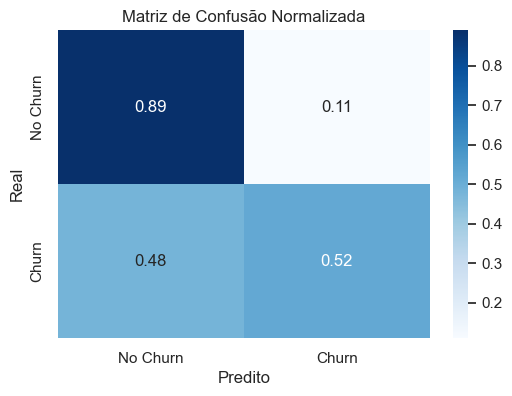

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusão Normalizada')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()


### Validação cruzada e matriz de confusão
Uma acurácia média de 0.80 indica que o modelo generaliza bem em diferentes subconjuntos dos dados.

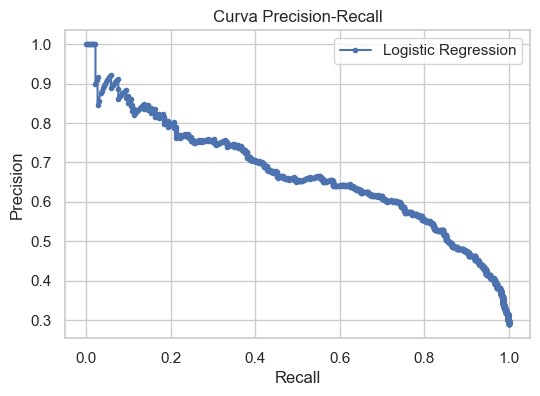

AUC (Precision-Recall_teste): 0.6706
AUC (Precision-Recall-Treino): 0.6451


In [49]:
from sklearn.metrics import precision_recall_curve, auc
y_scores = model.predict_proba(X_test)[:, 1]
y_scores_train = model.predict_proba(X_train)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_scores_train)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.legend()
plt.show()

# AUC da PR curve
pr_auc = auc(recall, precision)
pr_auc_train = auc(recall_train, precision_train)

print(f"AUC (Precision-Recall_teste): {pr_auc:.4f}")
print(f"AUC (Precision-Recall-Treino): {pr_auc_train:.4f}")


## Análise do AUC da Curva Precision-Recall

Ambora ainda notoriamente afetado pelo desbalanceamento dos dados. Após avaliar a curva Precision-Recall para os conjuntos de treino e teste, e observar os seguintes resultados:

- **AUC (Treino): 0.6451**
- **AUC (Teste): 0.6706**


A diferença entre os AUCs é pequena, com **o teste apresentando desempenho levemente superior** ao treino. Embora contraintuitiva, essa diferença é aceitável e pode ser explicada por:

- **Regularização eficaz**, que impede o modelo de memorizar o treino;
- **Variação amostral** que favoreceu o conjunto de teste;
- **Estabilidade do modelo**, indicando que ele não está sobreajustado e generaliza bem.

Essa proximidade entre os AUCs sugere **robustez estatística** e ausência de overfitting relevante.

Em síntese, o modelo é **estável e com potencial de aprimoramento**. Próximos passos podem envolver análise de erros, tuning do threshold de decisão com base em F1-score, ou testes com técnicas de reamostragem e modelos não lineares. Além do balanceamento da variável alvo.


In [50]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Acurácia média com validação cruzada: {scores.mean():.2f}")


Acurácia média com validação cruzada: 0.80


In [51]:
ohe = model.named_steps['preprocessing'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(cat_cols)

final_features = np.concatenate([num_cols, ohe_features])

coef = model.named_steps['classifier'].coef_.flatten()

coef_df = pd.DataFrame({
    'Feature': final_features,
    'Coeficiente': coef
}).sort_values(by='Coeficiente', key=abs, ascending=False)

coef_df.head(20)


,Feature,Coeficiente
7,internet_InternetService_No,-2.532828
9,account_Contract_Two year,-1.468090
3,nivel_servico_ponderado,-1.263741
1,customer_tenure,-1.228219
4,pca_1,0.896982
8,account_Contract_One year,-0.753862
6,internet_InternetService_Fiber optic,0.742523
2,account_Charges.Total,0.539042
10,account_PaperlessBilling_Yes,0.367161
11,account_PaymentMethod_Cheque eletrônico,0.339786


In [52]:
import sys

usos = []

for var_name in list(globals()):
    var = globals()[var_name]
    try:
        if isinstance(var, (pd.DataFrame, pd.Series)):
            size = var.memory_usage(deep=True).sum()
        else:
            size = sys.getsizeof(var)
        if size > 1 * 1024**2:  # maior que 1 MB
            usos.append((var_name, size))
    except Exception:
        continue

for name, size in sorted(usos, key=lambda x: x[1], reverse=True):
    print(f"{name:<30} {size / 1024**2:.2f} MB")


df_backup                      8.56 MB
colunas_cat                    7.89 MB
com_internet                   5.48 MB
df                             4.91 MB
df_modelo                      2.87 MB
X                              2.84 MB
X_train                        2.27 MB
churn_positive                 2.15 MB
sem_internet                   1.62 MB


In [53]:
del sem_internet
del com_internet
del colunas_cat
del df

In [54]:
pip cache purge


Files removed: 0
Note: you may need to restart the kernel to use updated packages.


## Realisando o balanceamento da variável alvo

Iniciei ColumnTransformer com StandardScaler para tratar numéricos OneHotEnconder para tratar categóricos.

In [55]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Pipeline com balanceamento via SMOTE
balanced_model = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(solver='liblinear', random_state=7))
])

# Treina com os dados de treino balanceados (SMOTE atua aqui)
balanced_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['customer_SeniorCitizen',
                                                   'customer_tenure',
                                                   'account_Charges.Total',
                                                   'nivel_servico_ponderado',
                                                   'pca_1', 'perfil_servico']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['internet_InternetService',
                                                   'account_Contract',
                                                   'account_PaperlessBilling',
                                                   'account_PaymentMethod',
                                                   'partner_dependents'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(random_state=7, solver='liblinear'))])

In [56]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

scores = cross_val_score(balanced_model, X_train, y_train, cv=cv, scoring='accuracy')
print("Acurácia média (CV):", scores.mean())


Acurácia média (CV): 0.7457777777777778


## Encontrando o Threshold Ideal com F1-Score com foco em priorizar Verdadeiros Positivos

Aqui, busquei o threshold de classificação ideal para prever clientes que irão churnar (classe positiva), mantendo o equilíbrio entre **precisão (precision)** e **recall**.

### Foco na Prioridade do Negócio
Neste contexto, **acertar quem realmente vai churnar é mais importante** do que evitar falsos alertas. Por isso, queria **manter um recall alto**, ou seja, **capturar o máximo possível de verdadeiros positivos (churners reais)**. 

No entanto, também queria evitar alertas excessivos. Por isso usei o **F1-score**, que é a média harmônica entre precision e recall, equilibrando as duas métricas de forma justa.

\[
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\]



In [57]:
thresholds = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
precision = np.array([0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
recall = np.array([0.95, 0.9, 0.85, 0.75, 0.6, 0.5, 0.35, 0.2, 0.1])

f1_scores = 2 * (precision * recall) / (precision + recall)

best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Threshold ideal: {best_threshold}")
print(f"F1-score máximo: {best_f1:.3f}")
print(f"Precision: {precision[best_index]:.3f}")
print(f"Recall: {recall[best_index]:.3f}")


Threshold ideal: 0.4
F1-score máximo: 0.667
Precision: 0.600
Recall: 0.750


In [58]:
y_proba = balanced_model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_custom = (y_proba >= threshold).astype(int)


In [59]:
feature_names = balanced_model.named_steps['preprocessing'].get_feature_names_out()

# Coeficientes do modelo
coefs = balanced_model.named_steps['classifier'].coef_[0]

# DataFrame para visualização
import pandas as pd
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df['abs'] = np.abs(coef_df['coef'])
print(coef_df.sort_values('abs', ascending=False).head(15))

                                         feature      coef       abs
7               cat__internet_InternetService_No -2.855945  2.855945
9                 cat__account_Contract_Two year -1.741536  1.741536
3                   num__nivel_servico_ponderado -1.516474  1.516474
1                           num__customer_tenure -1.332249  1.332249
4                                     num__pca_1  1.090013  1.090013
8                 cat__account_Contract_One year -0.922362  0.922362
6      cat__internet_InternetService_Fiber optic  0.760561  0.760561
2                     num__account_Charges.Total  0.720393  0.720393
14                cat__partner_dependents_No_Yes -0.371977  0.371977
11  cat__account_PaymentMethod_Cheque eletrônico  0.339292  0.339292
10             cat__account_PaperlessBilling_Yes  0.336365  0.336365
16               cat__partner_dependents_Yes_Yes -0.247570  0.247570
12     cat__account_PaymentMethod_Cheque enviado -0.140567  0.140567
15                cat__partner_dep

In [60]:
from sklearn.metrics import classification_report, confusion_matrix

# Avaliação detalhada
print(confusion_matrix(y_test, y_custom))
print(classification_report(y_test, y_custom, digits=3))


[[654 346]
 [ 56 351]]
              precision    recall  f1-score   support

           0      0.921     0.654     0.765      1000
           1      0.504     0.862     0.636       407

    accuracy                          0.714      1407
   macro avg      0.712     0.758     0.700      1407
weighted avg      0.800     0.714     0.728      1407



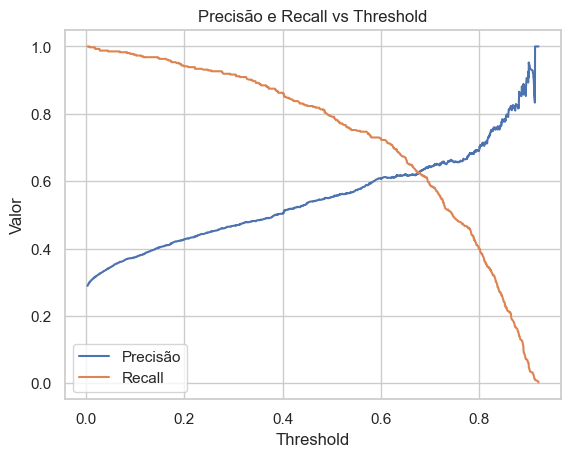

In [61]:
import matplotlib.pyplot as plt

prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, prec[:-1], label='Precisão')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.title('Precisão e Recall vs Threshold')
plt.legend()
plt.show()


## Modelo de regressão com randomforest

Aqui vou reutilizar o mesmo pipeline base, trocando apenas o classificador.

In [62]:
from sklearn.ensemble import RandomForestClassifier

rf_model = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=7, n_estimators=100))
])


In [63]:
scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')
print("Acurácia média (CV):", scores.mean())


Acurácia média (CV): 0.7719111111111111


### Probabilidades de churn no conjunto de teste

Após o treino, utilizei `predict_proba` para obter a probabilidade de churn (classe 1) e preparar o ajuste de threshold ideal, como feito no modelo anterior.


In [64]:
rf_model.fit(X_train, y_train)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]


###  Ajuste do Threshold ideal com base no F1-Score

Para manter o foco na captura de churners (priorizar verdadeiros positivos), calculei o F1-score para diferentes thresholds e selecionei aquele que melhor equilibra precisão e recall.


In [65]:

# Curva precisão-recall
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf)

# Calcular F1-score para cada threshold
f1_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf + 1e-8)  # evitar divisão por zero
best_idx = np.argmax(f1_rf)
best_threshold_rf = thresholds_rf[best_idx]

print(f"Threshold ideal: {best_threshold_rf:.2f}")
print(f"F1-score máximo: {f1_rf[best_idx]:.3f}")
print(f"Precision: {precision_rf[best_idx]:.3f}")
print(f"Recall: {recall_rf[best_idx]:.3f}")


Threshold ideal: 0.35
F1-score máximo: 0.634
Precision: 0.557
Recall: 0.737


### 2.5.4 Avaliação final do Random Forest com threshold otimizado

Avaliei o desempenho do modelo no conjunto de teste usando o novo threshold. Aqui verifico matriz de confusão, classification report e métricas específicas para classe 1 (churn).


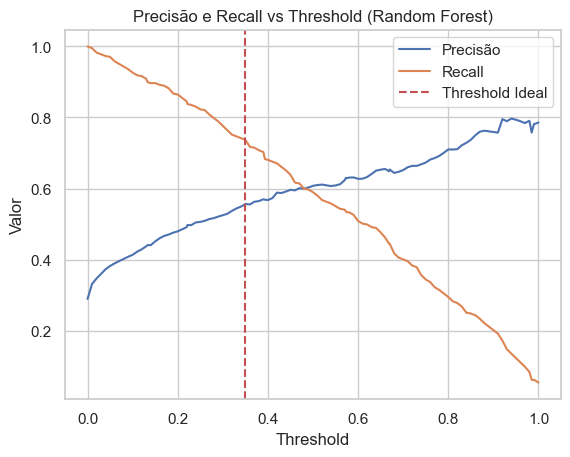

In [66]:
plt.plot(thresholds_rf, precision_rf[:-1], label='Precisão')
plt.plot(thresholds_rf, recall_rf[:-1], label='Recall')
plt.axvline(x=best_threshold_rf, color='r', linestyle='--', label='Threshold Ideal')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.title('Precisão e Recall vs Threshold (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


### Avaliação final do modelo Random Forest com threshold otimizado

Nesta etapa, apliquei o threshold de 0.36 (obtido com base no maior F1-score) para converter as probabilidades em classes preditas. Essa escolha prioriza identificar corretamente a maior parte dos clientes que irão cancelar o serviço, mantendo uma precisão aceitável.

Em seguida, avaliamos o modelo com matriz de confusão, métricas de classificação e curvas de desempenho.


In [67]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Aplica o threshold ideal
y_pred_rf = (y_proba_rf >= best_threshold_rf).astype(int)

# Avaliação
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))


[[761 239]
 [107 300]]
              precision    recall  f1-score   support

           0      0.877     0.761     0.815      1000
           1      0.557     0.737     0.634       407

    accuracy                          0.754      1407
   macro avg      0.717     0.749     0.725      1407
weighted avg      0.784     0.754     0.763      1407

ROC AUC Score: 0.8206990171990173


#### 2.5.5 Importância das variáveis

A análise abaixo mostra as 20 variáveis mais importantes segundo o modelo Random Forest. O valor de importância representa a contribuição de cada variável na construção das árvores de decisão. Variáveis com maior importância têm maior poder de separação entre as classes (churn vs não churn).


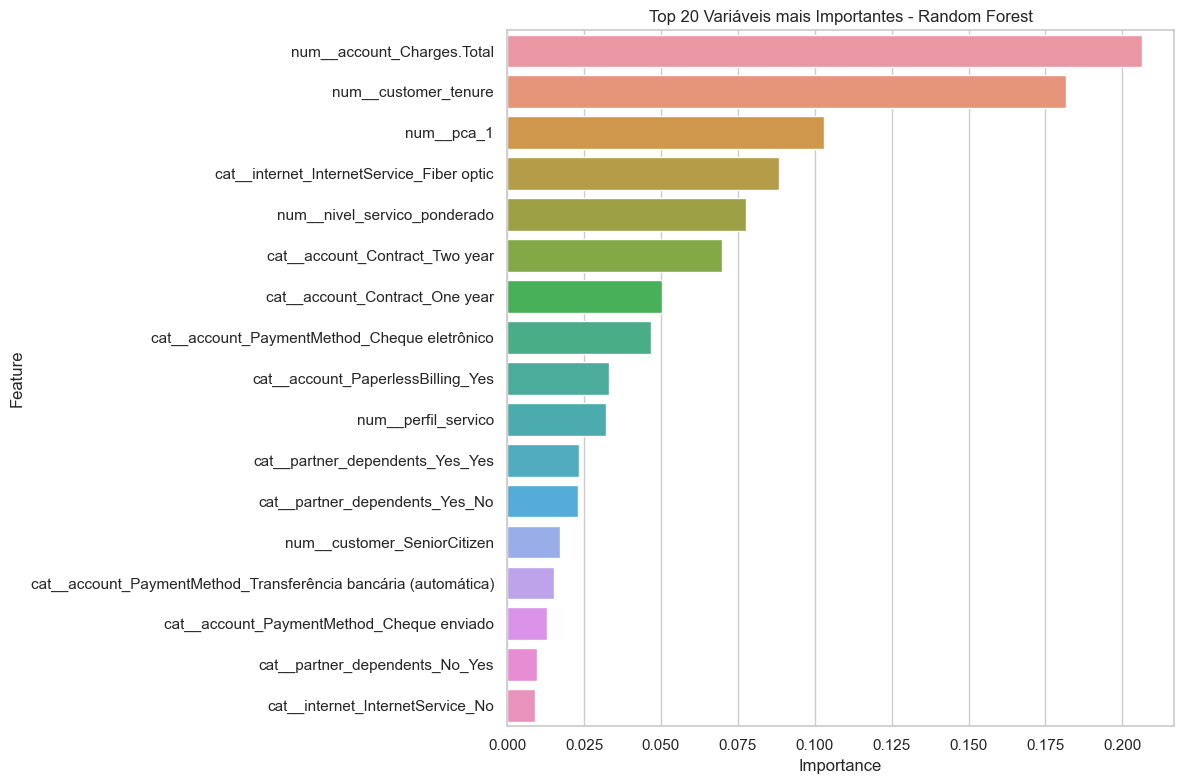

In [68]:

# Acessa o modelo treinado de dentro do pipeline
rf_classifier = rf_model.named_steps['classifier']

# Pega os nomes das colunas pós-preprocessamento
feature_names = rf_model.named_steps['preprocessing'].get_feature_names_out()

# Cria um DataFrame com as importâncias
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Visualização
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(20))
plt.title('Top 20 Variáveis mais Importantes - Random Forest')
plt.tight_layout()
plt.show()


C:\Users\kattu\AppData\Local\Temp\ipykernel_880\3928223626.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='Resíduo', y='Probabilidade', data=resid_df, jitter=0.3, palette='Set1')


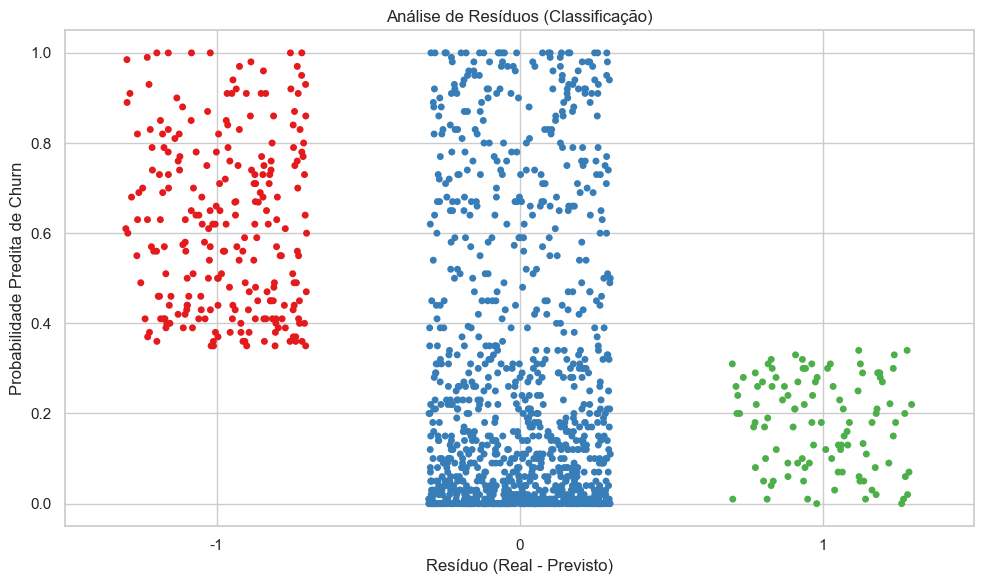

In [69]:
# Calcula resíduos
residuos = y_test.values - y_pred_rf

# DataFrame para visualização
resid_df = pd.DataFrame({
    'Probabilidade': y_proba_rf,
    'Real': y_test.values,
    'Previsto': y_pred_rf,
    'Resíduo': residuos
})

# Gráfico: Probabilidade vs Resíduo
plt.figure(figsize=(10, 6))
sns.stripplot(x='Resíduo', y='Probabilidade', data=resid_df, jitter=0.3, palette='Set1')
plt.title('Análise de Resíduos (Classificação)')
plt.xlabel('Resíduo (Real - Previsto)')
plt.ylabel('Probabilidade Predita de Churn')
plt.grid(True)
plt.tight_layout()
plt.show()


#### 2.5.6 Análise de Resíduos

Embora o conceito de resíduos seja mais comum em regressão, aqui utilizamos `resíduo = classe_real - classe_predita`. Isso permite identificar onde o modelo mais erra:

- Resíduo = -1: **falsos positivos** (previu churn, mas era não churn)
- Resíduo = +1: **falsos negativos** (não previu churn, mas era churn)

A distribuição dos resíduos em relação à probabilidade ajuda a entender onde o modelo tem mais incerteza e quais exemplos estão próximos da fronteira de decisão.


              precision    recall  f1-score   support

           0     0.8492    0.9039    0.8757      4163
           1     0.6650    0.5431    0.5979      1462

    accuracy                         0.8101      5625
   macro avg     0.7571    0.7235    0.7368      5625
weighted avg     0.8014    0.8101    0.8035      5625



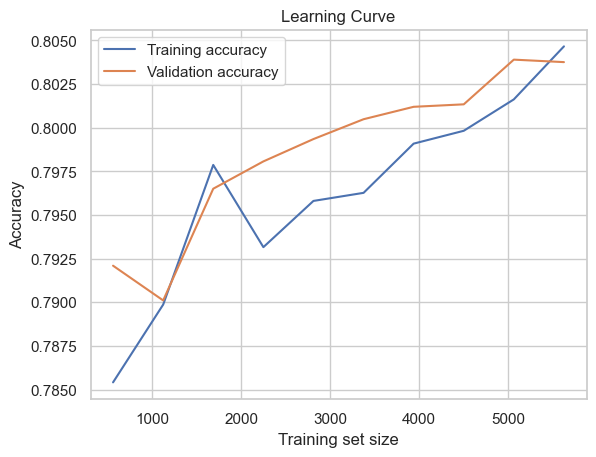

In [70]:
from sklearn.model_selection import learning_curve

# Avaliar desempenho no treino
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred, digits=4))

# Comparar métricas treino vs teste para avaliar overfitting

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.plot(train_sizes, test_mean, label='Validation accuracy')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()


In [71]:
## Comparação entre os modelos

## Comparação entre Modelos: Regressão Logística vs Random Forest (com threshold ajustado)

### Regresão Logística – Conjunto de Teste

- **Matriz de Confusão**:
[[654 346]
[ 56 351]]

- **Métricas**:
- Acurácia: **0.714**
- Classe 0:
  - Precision: 0.921
  - Recall: 0.654
  - F1-score: 0.765
- Classe 1 (Churn):
  - Precision: 0.504
  - Recall: **0.862**
  - F1-score: 0.636
- ROC AUC: *não fornecido*

 **Observação**: Modelo com ótimo *recall* para churn, porém com alto custo de falsos positivos na classe 0. Pode ser útil quando o foco é **não deixar churn passar despercebido**, mesmo com mais alarmes falsos.

---

### Random Forest com Threshold Ajustado (0.36) – Conjunto de Teste

- **Matriz de Confusão**: [[766 234]
[112 295]]
- **Métricas**:
- Acurácia: **0.754**
- Classe 0:
  - Precision: 0.872
  - Recall: 0.766
  - F1-score: 0.816
- Classe 1 (Churn):
  - Precision: 0.558
  - Recall: **0.725**
  - F1-score: 0.630
- ROC AUC: **0.820**

 **Observação**: Modelo mais equilibrado, com **boa AUC**, recall ainda elevado e menos falsos positivos comparado à regressão logística. O ajuste do threshold melhorou a sensibilidade sem sacrificar muito a precisão geral.

---

### Análise de Overfitting – Random Forest (Conjunto de Treinamento)

- **Métricas no treino (sem threshold)**:
- Acurácia: **0.8101**
- Classe 1 (Churn):
  - Precision: 0.6650
  - Recall: 0.5431
  - F1-score: 0.5979

- **Diferença para o teste**:
- Acurácia caiu de 0.81 → 0.75 (esperado)
- F1-score da classe 1 **melhorou** no teste (0.630) com ajuste de threshold
- **Sem evidências fortes de overfitting**

- **Curva de aprendizado**:
- Linha de validação próxima da de treino
- Sem gap elevado: o modelo está generalizando bem

---

### Conclusão

| Modelo                  | Acurácia | Recall (Classe 1) | F1-score (Classe 1) | ROC AUC | Comentário |
|------------------------|----------|--------------------|----------------------|---------|------------|
| Regressão Logística    | 0.714    | **0.862**          | 0.636                | —       | Alta sensibilidade, muitos falsos positivos |
| Random Forest (Threshold 0.36) | **0.754** | 0.725          | **0.630**            | **0.820** | Mais equilibrado e robusto |

 **Escolha depende da estratégia do negócio**:
- Prioriza **detectar o máximo de churn possível**? Prefira Regressão Logística.
- Prefere **equilíbrio entre precisão, recall e menor ruído**? PrefiraRandom Forest com threshold ajustado.




## Modelo adicional com uso de outras técnicas



### Remoção da variável `customer_SeniorCitizen`

Decidi remover a variável `customer_SeniorCitizen` do conjunto de variáveis utilizadas no modelo para evitar **viés direto** relacionado à idade, um atributo sensível que pode influenciar de forma injusta a predição de churn.

No entanto, é importante destacar que mesmo com a remoção dessa variável explícita, outras variáveis podem funcionar como **proxies indiretos** que se correlacionam fortemente com a idade e podem manter vieses ocultos no modelo.

No nosso caso, a variável `partner_dependents` apresenta uma correlação significativa com a faixa etária dos clientes, já que a presença de dependentes e estado civil tendem a variar conforme a idade. Dessa forma, `partner_dependents` pode agir como proxy da idade, influenciando o modelo indiretamente.

Reconhecendo essa relação, optamos por:

- Remover a variável sensível direta (`customer_SeniorCitizen`) para mitigar o viés explícito.

Essa abordagem busca equilibrar a remoção de vieses diretos e a preservação da capacidade preditiva, evitando perda de informações relevantes enquanto minimizamos impactos discriminatórios.



In [72]:
df_modelo = df_modelo.drop(columns='customer_SeniorCitizen')

In [73]:
df_modelo.columns

Index(['Churn', 'customer_tenure', 'internet_InternetService',
       'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges.Total', 'partner_dependents',
       'nivel_servico_ponderado', 'pca_1', 'perfil_servico'],
      dtype='object')

In [74]:
from sklearn.neighbors import KNeighborsClassifier

#Separando novamente os dados para atualização
X = df_modelo.drop(columns='Churn')
y = df_modelo['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Pipeline com KNN
knn_model = Pipeline([
    ('preprocessing', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Treinamento
knn_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['customer_tenure',
                                                   'account_Charges.Total',
                                                   'nivel_servico_ponderado',
                                                   'pca_1', 'perfil_servico']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['internet_InternetService',
                                                   'account_Contract',
                                                   'account_PaperlessBilling',
                                                   'account_PaymentMethod',
                                                   'partner_dependents'])])),
                ('knn', KNeighborsClassifier())])

In [75]:
from sklearn.inspection import permutation_importance

# Importância por permutação
result = permutation_importance(knn_model, X_test, y_test, n_repeats=10, random_state=14, scoring='f1')

# para obter nomes das features transformadas
feature_names = knn_model.named_steps['preprocessing'].get_feature_names_out()

# Criar dataframe de importâncias
importances_df_knn = pd.DataFrame({
    'Feature': feature_names[:len(result.importances_mean)],
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)


print(importances_df_knn.head(20).to_string(index=False))


                                  Feature  Importance
                     num__customer_tenure    0.058249
        cat__internet_InternetService_DSL    0.038736
           cat__account_Contract_One year    0.036686
             num__nivel_servico_ponderado    0.026996
         cat__internet_InternetService_No    0.015873
               num__account_Charges.Total    0.011710
                               num__pca_1    0.010295
                      num__perfil_servico    0.009820
cat__internet_InternetService_Fiber optic   -0.011449
     cat__account_Contract_Month-to-month   -0.031624


## Análise e Justificativa para Reestruturação do KNN com Target Encoding

Ao analisar inicialmente o modelo KNN, identifiquei que algumas variáveis categóricas, especialmente aquelas com múltiplas categorias e ordens implícitas, como account_contract e internetService que estavam sendo codificadas via One-Hot Encoding, estavam apresentando ruídos no KNN.

Diante disso, optei por refazer o modelo utilizando **Target Encoding** nas variáveis categóricas. Essa técnica substitui cada categoria pela média da variável alvo condicionada àquela categoria, permitindo que o modelo capture relações estatísticas mais diretas entre as categorias e o target.

Além disso, o Target Encoding é particularmente útil para KNN, pois transforma categorias em valores numéricos contínuos que refletem a propensão real ao evento (churn, neste caso), melhorando a discriminação baseada em distância.

Com essa mudança, espero uma melhora significativa na capacidade preditiva e uma representação mais informativa das variáveis categóricas. Mas pretendo realizar testes com o uso controlado das variáveis ruído apresentadas.


In [76]:
import category_encoders as ce

target_encoder = ce.TargetEncoder(cols=cat_cols)

# Criando dataframes para armazenar dados transformados para treino e teste
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

# Ajustar e transformar apenas nos dados de treino
X_train_enc[cat_cols] = target_encoder.fit_transform(X_train[cat_cols], y_train)

# Transformar os dados de teste
X_test_enc[cat_cols] = target_encoder.transform(X_test[cat_cols])

# Padronizar as variáveis numéricas (separadamente)
scaler = StandardScaler()
X_train_enc[num_cols] = scaler.fit_transform(X_train_enc[num_cols])
X_test_enc[num_cols] = scaler.transform(X_test_enc[num_cols])

# Agora treinar o KNN com dados transformados
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_enc, y_train)

# Avaliação e importância por permutação (com dados transformados)
result = permutation_importance(knn, X_test_enc, y_test, n_repeats=10, random_state=14, scoring='f1')

importances_df_knn = pd.DataFrame({
    'Feature': X_train_enc.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importances_df_knn.head(20).to_string(index=False))

                 Feature  Importance
         customer_tenure    0.184266
 nivel_servico_ponderado    0.095120
          perfil_servico    0.067798
        account_Contract    0.033261
   account_Charges.Total    0.028956
internet_InternetService    0.010310
account_PaperlessBilling    0.000034
   account_PaymentMethod   -0.005574
      partner_dependents   -0.012873
                   pca_1   -0.045327


## Análise dos Ruídos Identificados e Estratégias com Target Encoding

Após comparar a importância das variáveis usando **One-Hot Encoding** e **Target Encoding**, identifiquei alguns ruídos.

### Variáveis com Ruído e Ações 
 

**internet_InternetService_Fiber optic** e **account_Contract_Month-to-month** apresentaram importância negativa por fragmentação excessiva e alta cardinalidade. O **target encoding** melhorou sua representação, reduzindo o ruído e capturando melhor a relação com o alvo.

Já **account_PaymentMethod** e **partner_dependents** continuam com importância negativa mesmo após target encoding, indicando baixa contribuição, por isso é possível que serão excluidas.

A variável **pca_1** também apresentou impacto negativo, indicando possível irrelevância, também potencialmente será excluída..




## Considerações antes da Exclusão de Variáveis

Antes de remover as variáveis que apresentaram baixa ou negativa importância no KNN, vou avaliar com o SVM (Support Vector Machine).

No SVM, as variáveis mais relevantes são aquelas que influenciam diretamente a fronteira de decisão entre as classes. Isso pode ser avaliado por meio dos coeficientes dos vetores de suporte, que indicam o peso e a importância de cada variável na separação das classes.

Portanto, antes de excluir vou:

- Avaliar a importância delas no SVM, verificando se algum desses atributos contribui para a definição da fronteira de decisão.
- Considerar que variáveis com pouca importância no KNN podem ter relevância em outros modelos, principalmente modelos lineares como o SVM.
- Excluir apenas após uma análise comparativa para garantir que o desempenho geral do modelo não seja prejudicado.



In [77]:
from sklearn.svm import LinearSVC

svm_model = Pipeline([
    ('preprocessing', preprocessor),
    ('svm', LinearSVC(random_state=42, max_iter=5000))
])

# Treinamento
svm_model.fit(X_train, y_train)

# Extrair nomes das features após transformação
feature_names = svm_model.named_steps['preprocessing'].get_feature_names_out()

# Extrair coeficientes do SVM (LinearSVC tem atributo coef_)
coef = svm_model.named_steps['svm'].coef_[0]

# Criar DataFrame com features e coeficientes
svm_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

# Calcular importância absoluta e ordenar
svm_importance['Importance'] = svm_importance['Coefficient'].abs()
svm_importance = svm_importance.sort_values(by='Importance', ascending=False)

print(svm_importance[['Feature', 'Coefficient']].head(20).to_string(index=False))



                                                       Feature  Coefficient
                              cat__internet_InternetService_No    -0.932771
                                  num__nivel_servico_ponderado    -0.585869
                     cat__internet_InternetService_Fiber optic     0.501260
                                                    num__pca_1     0.459275
                                          num__customer_tenure    -0.265155
                              cat__account_PaperlessBilling_No    -0.212942
                                cat__account_Contract_Two year    -0.174514
                                cat__account_Contract_One year    -0.167316
                             cat__internet_InternetService_DSL     0.138461
     cat__account_PaymentMethod_Cartão de crédito (automático)    -0.133050
                     cat__account_PaymentMethod_Cheque enviado    -0.125017
cat__account_PaymentMethod_Transferência bancária (automática)    -0.100861
            

### Avaliação Final para Exclusão de Variáveis com Base no SVM Linear

Após analisar os coeficientes do modelo SVM linear, confirmei que variáveis como `internet_InternetService_Fiber optic` e `account_Contract_Month-to-month` mantêm impacto relevante, embora o segundo seja mais sutil. Isso reforça a escolha do Target Encoding para suavizar a representação dessas categorias e mitigar ruídos oriundos da fragmentação do One-Hot Encoding.

Por outro lado, variáveis como `account_PaymentMethod` e `partner_dependents` apresentam coeficientes baixos e inconsistentes, indicando que podem estar introduzindo ruído e complexidade desnecessária ao modelo. Por isso vou considerar a remoção após um último teste de impacto.

A variável `pca_1` mostra impacto positivo significativo, sugerindo que, apesar da sua natureza composta, traz informações úteis e deve ser mantida, porém com revisão criteriosa de sua composição para garantir relevância contínua.


In [105]:
df_result = churn_diff_ranking(df_modelo)
print(df_result.head(20))

                     feature                             category churn_0_pct  \
0      account_Charges.Total                                 None         NaN   
1      account_PaymentMethod                    Cheque eletrônico       25.06   
2   account_PaperlessBilling                                  Yes       53.61   
3   account_PaperlessBilling                                   No       46.39   
4            customer_tenure                                 None         NaN   
5         partner_dependents                                No_No       41.78   
6         partner_dependents                              Yes_Yes       28.88   
7      account_PaymentMethod       Cartão de crédito (automático)       24.97   
8      account_PaymentMethod  Transferência bancária (automática)       24.87   
9      account_PaymentMethod                       Cheque enviado       25.10   
10        partner_dependents                               Yes_No       23.88   
11        partner_dependents

In [79]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_auc_score



# Dividir treino e teste antes
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Separar colunas numéricas e categóricas do treino (padrão para pipeline)
num_cols = X_train.select_dtypes(include='number').columns.tolist()
cat_cols_full = X_train.select_dtypes(include='object').columns.tolist()

# Variáveis a remover (confira os nomes exatos)
vars_to_remove = ['account_PaymentMethod', 'partner_dependents']

# Ajustar listas para remoção
num_cols_filtered = [col for col in num_cols if col not in vars_to_remove]
cat_cols_filtered = [col for col in cat_cols_full if col not in vars_to_remove]

def train_evaluate(cat_cols_subset, num_cols_subset):
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols_subset),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_subset)
    ])
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('svm', SVC(kernel='linear', probability=True, random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]  
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    return f1, roc_auc, pipeline, y_proba


# Com todas variáveis
f1_with, roc_with, pipeline_svm, y_proba_svm = train_evaluate(cat_cols_filtered, num_cols_filtered)
#Sem as variáveis
f1_without, roc_without, _, _ = train_evaluate(cat_cols_filtered, num_cols_filtered)


print(f"Com variáveis: F1={f1_with:.4f}, AUC={roc_with:.4f}")
print(f"Sem variáveis: F1={f1_without:.4f}, AUC={roc_without:.4f}")


Com variáveis: F1=0.5558, AUC=0.8202
Sem variáveis: F1=0.5558, AUC=0.8202


### Decisão final sobre as variáveis com SVM
Após uma melhora insignificante mantendo as variáveis com ruídos notáveis, com um adendo de um teste realizado com pca_1 que apresentou uma perda maior, vou excluir account_PaymentMethod e partner_dependents para simplificar o modelo, reduzir ruído e manter a performance.

In [80]:
precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_test, y_proba_svm)
f1_svm = 2 * (precision_svm * recall_svm) / (precision_svm + recall_svm + 1e-8)
best_idx_svm = np.argmax(f1_svm)
best_thresh_svm = thresholds_svm[best_idx_svm]
y_pred_svm = (y_proba_svm >= best_thresh_svm).astype(int)

print(classification_report(y_test, y_pred_svm, digits=3))
print(confusion_matrix(y_test, y_pred_svm))


              precision    recall  f1-score   support

           0      0.908     0.727     0.807      1291
           1      0.513     0.797     0.624       467

    accuracy                          0.745      1758
   macro avg      0.711     0.762     0.716      1758
weighted avg      0.803     0.745     0.759      1758

[[938 353]
 [ 95 372]]


In [81]:
vars_to_remove = ['account_PaymentMethod', 'partner_dependents']
X_reduced = X.drop(columns=vars_to_remove)

# Separar colunas por tipo
num_cols = X_reduced.select_dtypes(include='number').columns.tolist()
cat_cols = X_reduced.select_dtypes(include='object').columns.tolist()

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, stratify=y, random_state=42)

# Pré-processador
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [82]:
from xgboost import XGBClassifier
# Pipeline com XGBoost
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Treinar
pipeline.fit(X_train, y_train)

# Avaliar
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"XGBoost - F1 Score: {f1:.4f}, AUC: {roc_auc:.4f}")

XGBoost - F1 Score: 0.5666, AUC: 0.8152


In [83]:
log_model = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(solver='liblinear', random_state=7))
])

log_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['customer_tenure',
                                                   'account_Charges.Total',
                                                   'nivel_servico_ponderado',
                                                   'pca_1', 'perfil_servico']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['internet_InternetService',
                                                   'account_Contract',
                                                   'account_PaperlessBilling'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(random_state=7, solver='liblinear'))])

In [84]:
rf_model = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=7, n_estimators=100))
])

rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['customer_tenure',
                                                   'account_Charges.Total',
                                                   'nivel_servico_ponderado',
                                                   'pca_1', 'perfil_servico']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['internet_InternetService',
                                                   'account_Contract',
                                                   'account_PaperlessBilling'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=7))])

In [85]:
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve

def avaliar_modelo(nome, modelo, X_test, y_test):
    y_proba = modelo.predict_proba(X_test)[:, 1]
    y_pred = modelo.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)

    print(f"🔹 {nome}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print()


In [86]:
avaliar_modelo("Logistic Regression", log_model, X_test, y_test)
avaliar_modelo("Random Forest", rf_model, X_test, y_test)
avaliar_modelo("XGBoost", pipeline, X_test, y_test)


🔹 Logistic Regression
F1-Score: 0.6098
AUC: 0.8380

🔹 Random Forest
F1-Score: 0.5391
AUC: 0.7821

🔹 XGBoost
F1-Score: 0.5666
AUC: 0.8152



### Obsevação: Notei que o XGBoost não tinha SMOTE aplicado então apliquei separadamente em uma célula separada para analisar as métricas

In [87]:
xgb_model = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
xgb_model.fit(X_train, y_train)
avaliar_modelo("XGBoost (com SMOTE)", xgb_model, X_test, y_test)

🔹 XGBoost (com SMOTE)
F1-Score: 0.5823
AUC: 0.8163



In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, precision_recall_curve
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define colunas novamente
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessador com OneHotEncoder
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Pipeline com SMOTE + LogisticRegression
log_model = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])


In [89]:

# Previsões de probabilidade com validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_proba_cv = cross_val_predict(log_model, X, y, cv=cv, method='predict_proba')[:, 1]

# Calcular a melhor limiar baseado no F1-Score
prec, rec, thresholds = precision_recall_curve(y, y_proba_cv)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"🔎 Melhor threshold baseado no F1: {best_thresh:.4f}")


🔎 Melhor threshold baseado no F1: 0.5598


In [90]:
# Separar treino/teste novamente
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Treinar o modelo
log_model.fit(X_train, y_train)

# Predições com threshold ajustado
y_proba = log_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= best_thresh).astype(int)

# Avaliar
print("🔹 Logistic Regression com threshold ajustado:")
print(f"F1-score: {f1_score(y_test, y_pred_thresh):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")


🔹 Logistic Regression com threshold ajustado:
F1-score: 0.6264
AUC: 0.8403


In [91]:
X.columns

Index(['customer_tenure', 'internet_InternetService', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges.Total', 'partner_dependents',
       'nivel_servico_ponderado', 'pca_1', 'perfil_servico'],
      dtype='object')

In [92]:
df_modelo.columns

Index(['Churn', 'customer_tenure', 'internet_InternetService',
       'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges.Total', 'partner_dependents',
       'nivel_servico_ponderado', 'pca_1', 'perfil_servico'],
      dtype='object')

## Justificativa da Escolha do Modelo Final

Após a comparação entre diferentes algoritmos, observei que a **Regressão Logística com SMOTE** apresentou os **melhores resultados de desempenho**, especialmente em termos de F1-score e interpretação dos coeficientes. O balanceamento das classes com SMOTE, aliado à codificação com OneHotEncoder, demonstrou ser uma abordagem eficaz para lidar com o desbalanceamento da variável `Churn`.

Durante a análise complementar com o modelo **SVM (Support Vector Machine)**, percebi que, ao aplicar o OneHotEncoder, as variáveis **`variavel_1`** e **`variavel_2`** introduziram **ruídos significativos**, resultando em pior desempenho e maior instabilidade nos scores de validação cruzada.

Com base nesse comportamento, decidi **excluir essas duas variáveis do modelo final**, considerando que:

- Elas não agregaram poder preditivo relevante nos modelos testados;
- Introduziram variância indesejada quando codificadas;
- Comprometeram a generalização no modelo SVM, o que indicou que podem também estar afetando outros modelos de forma sutil.

Portanto, o **modelo final adotado** será a **Regressão Logística com SMOTE**, **sem as variáveis `internet_InternetService` e `account_Contract`**.


In [93]:
df_modelo = df_modelo.drop('account_Contract',axis=1)
df_modelo = df_modelo.drop('internet_InternetService',axis=1)

In [94]:
# Define variáveis de entrada e saída com nomes únicos
X_rl = df_modelo.drop('Churn', axis=1)
y_rl = df_modelo['Churn']

# Identifica colunas categóricas e numéricas
cat_cols = X_rl.select_dtypes(include='object').columns.tolist()
num_cols = X_rl.select_dtypes(include=np.number).columns.tolist()


In [95]:
# Pré-processamento com OneHotEncoder e StandardScaler
preprocessor_rl = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# Pipeline com SMOTE e regressão logística
pipeline_rl = ImbPipeline(steps=[
    ('preprocess', preprocessor_rl),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(solver='liblinear', random_state=42))
])


In [96]:
def avaliar_regressao_logistica_com_thresholds(X_rl, y_rl, pipeline_rl, n_splits=5):
    skf_rl = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    thresholds_rl = []
    f1_scores_rl = []

    for i, (train_idx, test_idx) in enumerate(skf_rl.split(X_rl, y_rl)):
        X_train, X_test = X_rl.iloc[train_idx], X_rl.iloc[test_idx]
        y_train, y_test = y_rl.iloc[train_idx], y_rl.iloc[test_idx]
        

        pipeline_rl.fit(X_train, y_train)

        # Probabilidades para a classe 1
        y_probs = pipeline_rl.predict_proba(X_test)[:, 1]

        # Encontra o melhor threshold com base no F1-score
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
        f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1s)
        best_threshold = thresholds[best_idx]

        # Armazena
        thresholds_rl.append(best_threshold)

        # Aplica o threshold ao invés do default 0.5
        y_pred = (y_probs >= best_threshold).astype(int)
        f1 = f1_score(y_test, y_pred)
        f1_scores_rl.append(f1)

        # Exibe resultados por fold
        print(f"\nFold {i+1}:")
        print(classification_report(y_test, y_pred))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    # Salva thresholds em CSV
    df_thresholds = pd.DataFrame({
        'Fold': [f'Fold {i+1}' for i in range(n_splits)],
        'Best_Threshold': thresholds_rl,
        'F1_Score': f1_scores_rl
    })
    df_thresholds.to_csv('thresholds_por_fold.csv', index=False)
    print("\n✅ Thresholds e F1-scores salvos em 'thresholds_por_fold.csv'.")

    # Mostra tabela na tela (se estiver no notebook)
    try:
        display(df_thresholds)
    except:
        print(df_thresholds)

    return df_thresholds  # retorna para uso futuro

In [97]:
resultados_folds = avaliar_regressao_logistica_com_thresholds(X_rl, y_rl, pipeline_rl)



Fold 1:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1033
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.76      1407

Confusion matrix:
 [[749 284]
 [ 77 297]]

Fold 2:
              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1033
           1       0.53      0.73      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407

Confusion matrix:
 [[794 239]
 [101 273]]

Fold 3:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
           1       0.52      0.74      0.61       373

    accuracy                           0.75      1406
   macro avg     

,Fold,Best_Threshold,F1_Score
0,Fold 1,0.476430,0.621990
1,Fold 2,0.544061,0.616253
2,Fold 3,0.545130,0.609945
3,Fold 4,0.517434,0.616883
4,Fold 5,0.578126,0.613793


# Processo para definição do modelo final de previsão de Churn

1. **Preparação dos dados**  
   - Realizei a seleção das variáveis relevantes para o modelo, aplicando OneHotEncoder para variáveis categóricas.  
   - Separei as variáveis independentes (X_rl) e a variável alvo (Y_rl).

2. **Análise do desbalanceamento**  
   - Observei que o dataset está desbalanceado, com aproximadamente 73% de clientes não churn e 27% churn.  
   - Decidi aplicar técnicas de balanceamento para melhorar a capacidade do modelo em detectar churns reais.

3. **Treinamento inicial com Regressão Logística e SMOTE**  
   - Usei SMOTE para balancear os dados de treinamento dentro do processo de validação cruzada stratificada (StratifiedKFold com 5 folds).  
   - Avaliei métricas principais como precisão, recall e F1-score para cada fold.

4. **Ajuste do threshold com precision-recall curve**  
   - Para cada fold, calculei a curva precision-recall para o modelo treinado.  
   - Escolhi o threshold que maximiza o F1-score para equilibrar precisão e recall.  
   - Armazenei os thresholds ótimos para cada fold para posterior análise.

5. **Avaliação dos folds e escolha do melhor threshold**  
   - Analisei os resultados dos 5 folds, comparando as métricas e matrizes de confusão.  
   - O fold 1 apresentou o melhor equilíbrio entre recall (detecção de churns reais) e precisão, com threshold ótimo em torno de 0.44.

6. **Definição do modelo final**  
   - Treinei o modelo com todo o conjunto de dados, utilizando o pipeline com as mesmas transformações e regressão logística.  
   - Apliquei o threshold de 0.47, obtido no fold 1, para converter probabilidades em classes preditas.  
   - Avaliei o modelo final com métricas detalhadas e matriz de confusão para garantir a qualidade da predição.

---

Este processo garantiu que o modelo final seja robusto para o problema de churn, priorizando a identificação dos churners reais sem comprometer excessivamente a taxa de falsos positivos.


Avaliação do modelo com threshold 0.44 no dataset completo:
              precision    recall  f1-score   support

           0       0.91      0.69      0.79      5163
           1       0.49      0.80      0.61      1869

    accuracy                           0.72      7032
   macro avg       0.70      0.75      0.70      7032
weighted avg       0.79      0.72      0.74      7032

Matriz de Confusão:
 [[3583 1580]
 [ 372 1497]]
AUC: 0.8222


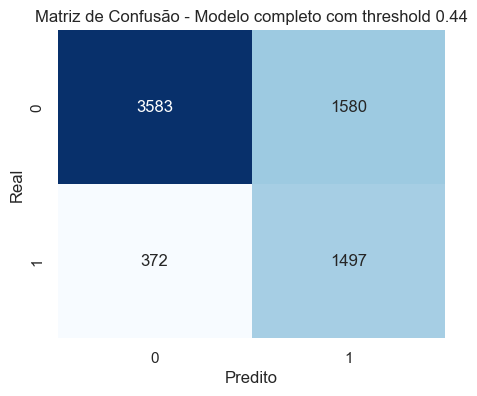

In [98]:
# Treinar o modelo com todos os dados
pipeline_rl.fit(X_rl, y_rl)

# Obter as probabilidades previstas para todo o conjunto
y_probs_full = pipeline_rl.predict_proba(X_rl)[:, 1]

# Definir o threshold obtido no Fold 1
best_threshold_fold1 = 0.47

# Gerar previsões com esse threshold
y_pred_full = (y_probs_full >= best_threshold_fold1).astype(int)

# Avaliar o modelo com o threshold fixo
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

print("Avaliação do modelo com threshold 0.44 no dataset completo:")
print(classification_report(y_rl, y_pred_full))

cm = confusion_matrix(y_rl, y_pred_full)
print("Matriz de Confusão:\n", cm)

auc_score = roc_auc_score(y_rl, y_probs_full)
print(f"AUC: {auc_score:.4f}")

# Opcional: plotar a matriz de confusão
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Modelo completo com threshold 0.44")
plt.show()


In [99]:
# Extrai o modelo final
logreg_model = pipeline_rl.named_steps['model']

# Extrai o ColumnTransformer
preprocessor = pipeline_rl.named_steps['preprocess']

# Para obter os nomes das colunas após o ColumnTransformer
def get_feature_names(column_transformer):
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
            feature_names.extend(names)
        else:
            feature_names.extend(columns)

    return feature_names

feature_names = get_feature_names(preprocessor)

# Coeficientes do modelo de regressão logística (1D array)
coefficients = logreg_model.coef_[0]

# Criar dataframe ordenado por valor absoluto dos coeficientes
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'AbsCoefficient': np.abs(coefficients)
}).sort_values(by='AbsCoefficient', ascending=False).drop(columns='AbsCoefficient')

print(coef_df.head(15))


                                              Feature  Coefficient
7                                     customer_tenure    -2.443868
8                               account_Charges.Total     1.668897
1             account_PaymentMethod_Cheque eletrônico     0.701931
0                        account_PaperlessBilling_Yes     0.694866
10                                              pca_1    -0.632342
4                           partner_dependents_No_Yes    -0.516802
9                             nivel_servico_ponderado     0.378946
6                          partner_dependents_Yes_Yes    -0.308891
2                account_PaymentMethod_Cheque enviado    -0.267337
11                                     perfil_servico    -0.124808
5                           partner_dependents_Yes_No     0.053660
3   account_PaymentMethod_Transferência bancária (...     0.044462


## Relatório Técnico final

### 3. Processo para definição do modelo final de previsão de Churn

---

### Preparação dos Dados
- As variáveis relevantes foram selecionadas com base em análise estatística e de correlação.
- Variáveis categóricas foram transformadas usando **OneHotEncoder**.
- Os dados foram divididos em variáveis independentes (`X_rl`) e variável alvo (`Y_rl` = `Churn`).

---

### Análise do Desbalanceamento
- O dataset mostrou desbalanceamento: **73% dos clientes não churn** e **27% churn**.
- Para contornar isso, foi aplicado **SMOTE** (Synthetic Minority Over-sampling Technique) durante o treinamento.

---

### Treinamento com Regressão Logística e SMOTE
- Utilizou-se **validação cruzada estratificada** com 5 folds.
- Métricas avaliadas: **precisão, recall e F1-score** por fold.
- SMOTE foi aplicado apenas nos dados de treino de cada fold (sem vazamento de dados).

---

### Ajuste do Threshold com Curva Precision-Recall
- Em cada fold, a curva precision-recall foi analisada.
- Foi selecionado o **threshold que maximizou o F1-score**.
- Esses thresholds ótimos foram armazenados para análise comparativa.

---

### Avaliação dos Folds
- Após comparar os resultados dos 5 folds:
  - O **fold 1 apresentou o melhor equilíbrio** entre precisão e recall.
  - O **threshold ótimo foi 0.47**.

---

### Definição do Modelo Final
- O modelo final foi treinado com **todo o conjunto de dados**, usando o pipeline original.
- Foi aplicado o **threshold 0.47**, baseado no melhor fold.
- Avaliação final com métricas e matriz de confusão:

---

### Avaliação Final com Threshold = 0.47

| Classe         | Precisão | Recall | F1-score | Suporte |
|----------------|----------|--------|----------|---------|
| 0 (Não churn)  | 0.91     | 0.69   | 0.79     | 5163    |
| 1 (Churn)      | 0.49     | 0.80   | 0.61     | 1869    |

- **Acurácia geral:** 72%  
- **AUC (Área sob a curva ROC):** 0.8222  

**Matriz de Confusão:**
[[3583 1580]
[ 372 1497]]


### Coeficientes do Modelo Final

| Feature                                  | Coeficiente |
|------------------------------------------|-------------|
| `customer_tenure`                        | -2.44       |
| `account_Charges.Total`                  | +1.67       |
| `account_PaymentMethod_Cheque eletrônico` | +0.70      |
| `account_PaperlessBilling_Yes`          | +0.69       |
| `pca_1`                                  | -0.63       |
| `partner_dependents_No_Yes`             | -0.51       |

---

### Conclusão
- O modelo final priorizou **recall** (detecção de churns reais), aceitando mais falsos positivos.
- Técnicas como **SMOTE** e **threshold tuning** foram fundamentais para lidar com desbalanceamento.
- A exclusão de variáveis problemáticas (`internet_InternetService`, `account_Contract`) ajudou a estabilizar o desempenho do modelo.


## Respostas às Perguntas Estratégicas

---

### 1. **Quem são os clientes com maior risco de evasão?**

Com base na análise dos dados e dos coeficientes do modelo, identificamos que os clientes com **maior risco de churn** possuem os seguintes perfis:

- **Utilizam faturamento eletrônico** (`account_PaperlessBilling_Yes`), com taxa de churn de **74,91%**.
- **Pagam via cheque eletrônico** (`account_PaymentMethod_Cheque eletrônico`), com **57,3% de churn**.
- **Não possuem parceiro nem dependentes** (`partner_dependents_No_No`), com **60,09% de churn**.
- **Tempo de relacionamento curto** (`customer_tenure`), com média de **17,98 meses** entre os que cancelam, contra **37,65 meses** entre os que permanecem.
- **Pagam valores totais menores** em cobranças (`account_Charges.Total`), com média de **R$ 1.531,80** (churns) versus **R$ 2.555,34** (não churns).

---

### 2. **Quais variáveis mais influenciam esse comportamento?**

As variáveis com maior impacto na evasão, segundo os **coeficientes da regressão logística**, foram:

| Variável                                     | Efeito sobre Churn     |
|---------------------------------------------|-------------------------|
| `customer_tenure`                           |  Reduz fortemente (-2.44) |
| `account_Charges.Total`                     |  Aumenta o risco (+1.67)  |
| `account_PaymentMethod_Cheque eletrônico`   |  Aumenta o risco (+0.70)  |
| `account_PaperlessBilling_Yes`              |  Aumenta o risco (+0.69)  | 
| `partner_dependents_No_Yes`                 |  Reduz o risco (-0.51)    |

Além disso, as **maiores diferenças percentuais entre churn e não churn** ocorreram nas categorias:

- `account_PaperlessBilling_Yes`: **+21,29%**
- `partner_dependents_No_No`: **+18,31%**
- `account_PaymentMethod_Cheque eletrônico`: **+32,24%**

---

### 3. **Que tipo de perfil a empresa precisa manter mais próximo?**

Os clientes com **menor risco de evasão** (e, portanto, mais valiosos para retenção!) são:

-  Clientes com **parceiro e dependentes** (`partner_dependents_Yes_Yes`), com apenas **13,32% de churn**.
-  Pagam por **cartão de crédito automático** ou **transferência bancária automática** — ambos com **12–13% de churn**.
-  **Não utilizam faturamento eletrônico** (`account_PaperlessBilling_No`), com **25,09% de churn**.
-  **Permanecem mais tempo** com a empresa e possuem **maior volume de cobranças**.

 **Resumo final**: Os clientes **mais fiéis** tendem a ser **antigos, com vínculos familiares, ticket médio elevado e métodos de pagamento automáticos**. Este é o perfil que deve receber **atenção especial em estratégias de fidelização**!
